In [6]:
from keras import backend as K
# Accuracy ne prenant pas en compte les charactères complétés

# Remove this when the cosineSimilarity will be added
def cosineSimilarity(h1, h2):
    return 2.3

def ignore_class_accuracy(to_ignore=2):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

# Fonction qui imitte le comportement du réseau de neurone
def get_hidden_state (word):
    prec = 0.005
    output = []
    
    for i, char in enumerate(word):
        if char == "a":
            prec = 0.02*(i+1) + prec
            output.append(prec)
        elif char == "b":
            prec = 0.03*(i+1) + prec
            output.append(prec)
        elif char == "e":
            prec = 0.005*(i+1) + prec
            output.append(prec)
        else:
            prec = 0.05*(i+1) + prec
            output.append(prec)
    return output


def get_data(filepath):

    inputs = []
    outputs = []
    with open(filepath, 'r') as f:
        lines = f.readlines()
    #print(lines[:3])


    #max_length = 0

    for line in lines:
        res = ""
        isInput = True
        for symbol in line:
            if symbol in [',', '\n']:
                if isInput:
                    inputs.append(res)
                    #max_length = len(res) if len(res) > max_length else max_length
                    res = ""
                    isInput = not isInput
                    continue
                else:
                    outputs.append(res)
            res += symbol
        #print(line)
    return inputs, outputs


def class_mapping(label, numb_class = 3):
    y_train = []
    for x in label:
        assert int(x) < numb_class
        y_train.append([int(i==int(x)) for i in range(numb_class)])
        
    return y_train

def tokenization(word, num_token = 4):
    x_train = []
    for x in word:
        if x == 'a':
            x_train.append(1)
        elif x == 'b':
            x_train.append(2)
        elif x == 'e':
            x_train.append(3)
        else:
            x_train.append(0)
    
    return x_train

def masking(word, pad_char = 'z'):
    return [x!=pad_char for x in word]

In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Embedding
import json
import numpy as np

def Tagger(n_tokens = 4, embedding_vector_length = 10, hidden_dim = 10, n_labels = 3, return_states = False):
    model = Sequential()
    model.add(Embedding(n_tokens, embedding_vector_length))
    model.add(SimpleRNN(hidden_dim, return_sequences=True))
    if not return_states:
        model.add(Dense(n_labels, activation='softmax'))
    return model

# These two functions work only for the specified configuration of the network
"""def save_weights(model, filename):
    weights = []
    for layer in model.layers:
        w = []
        [w.append(x.tolist()) for x in layer.get_weights()]
        weights.append(w)
    
    with open(filename, 'w') as f:
        json.dump(weights, f)"""

def load_weights(model, filename):
    with open(filename, 'r') as f:
        weights = json.load(f)



In [114]:
from utils import *
id = 0
print('\n\n\n'+'*'*20+f' ID {id}: '+' TRAINING THE RECURRENT NEURAL NETWORK '+'*'*20+'\n\n\n')
#max_length = 4
#corpus = ['ba', 'b', 'a', 'baa', 'a', 'baaa', 'aa', 'b', 'abaa', 'abb', 'bb']
#labels = ['11', '1', '1', '110', '1', '1100', '10', '1', '1010', '101', '11']
corpus, labels = get_data(f'./datasets/dataset{id}.txt')


max_length = len(max(corpus, key=len))

print(f'The corpus is {corpus[:5]}')
print(f'The labels are {labels[:5]}')
dev_percentage = 0.2
dev_size = int(dev_percentage * len(corpus))
dev_corpus = corpus[len(corpus) - dev_size:]
dev_labels = labels[len(corpus) - dev_size:]
dev_max_length = len(max(dev_corpus, key=len))

corpus = corpus[:len(corpus) - dev_size]
labels = labels[:len(labels) - dev_size]
corpus_, labels_ = preprocessing(corpus, labels, max_length)
dev_corpus_, dev_labels_ = preprocessing(dev_corpus, dev_labels, dev_max_length)

dev_mask = [masking(x) for x in dev_corpus_]

"""corpus_ = ["e"+x+"z"*(max_length - len(x)) for x in corpus]
labels_ = ["0"+x+"2"*(max_length - len(x)) for x in labels]"""
states = []
print(f'\nThe length of corpus is: {len(corpus)}\n')

x_train = np.array([tokenization(x) for x in corpus_])
y_train = np.array([class_mapping(x) for x in labels_])

x_test = np.array([tokenization(x) for x in dev_corpus_])
y_test = np.array([class_mapping(x) for x in dev_labels_])

mask = np.array([masking(x) for x in corpus_])



"""version_name = '01'
model_dir = os.path.join("weigths", version_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
filepath = "weigths/model_weights.h5\""""

optimizer = keras.optimizers.Adam(learning_rate=0.001)
batch_size = 50
n_epochs = 20

model = Tagger(4, 10, 10, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size, n_epochs)
# bacth de taille 2

loss = history.history['loss'][-1]
accuracy = history.history['accuracy'][-1]
#print('\n\n\n Les prédictions sont: \n\n')
#print(train_preds)

print(f'\n\n The categorical crossentropy loss: {loss}')
print(f'\n\n The accuracy: {accuracy*100}')




******************** ID 0:  TRAINING THE RECURRENT NEURAL NETWORK ********************



The corpus is ['bba', 'abbabbbbba', 'aabaaba', 'bb', 'aa']
The labels are ['111', '1011011111', '1001001', '11', '10']

The length of corpus is: 800

Epoch 1/20
16/16 [==============================] - 3s 11ms/step - loss: 1.0313 - accuracy: 0.5796
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 0.8874 - accuracy: 0.7040
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 0.7764 - accuracy: 0.7040
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6882 - accuracy: 0.7056
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.6150 - accuracy: 0.7746
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5455 - accuracy: 0.8462
Epoch 7/20
16/16 [==============================] - 0s 10ms/step - loss: 0.4724 - accuracy: 0.8904
Epoch 8/20
16/16 [==============================] - 0s 7ms/step 

In [104]:
predictions = model.predict(x_test)

7/7 [==============================] - 0s 5ms/step


In [97]:
print(x_test[:5])
print(y_test[:5])

[[2 0 1 3 3 3 3 3 3 3 3 3]
 [2 0 1 1 0 0 1 0 3 3 3 3]
 [2 1 1 0 1 1 0 0 3 3 3 3]
 [2 1 1 1 3 3 3 3 3 3 3 3]
 [2 0 0 0 0 0 0 0 0 3 3 3]]
[[[1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [1 0 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]]


2

In [118]:
def list_to_string(list_, mask):
    string = ''
    for i, x in enumerate(list_):
        if i == 0:
            continue
        if mask[i]:
            string += f'{x}'
    return string

def nparray_to_string(predictions, mask):
    preds = predictions.tolist()
    labels = []
    for i, x in enumerate(preds):
        labels.append(list_to_string(x, mask[i]))

    return labels

In [113]:
for i in dev_corpus_:
    if len(i) != 12:
        print(i)

In [119]:
dev_mask

[[True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True, True, True, True, True, True, True, True, False, False, False, False],
 [True, True, True, True, True, True, True, True, False, False, False, False],
 [True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True, True, True, True, True, True, True, True, True, False, False, False],
 [True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True, True, True, True, True, True, True, True, True, True, False, False],
 [True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True, True, True, True, True, True, True, False, False, False, False, False],
 [True, True, True, True, True, True, True, True, False, False, False, False],
 [Tr

In [120]:
for i in dev_mask:
    if len(i) != 12:
        print(i)

In [111]:
print(np.asarray(dev_mask).shape)
print(predictions.argmax(axis=-1).shape)

(200,)
(200, 12)


C:\Users\Gael\AppData\Local\Temp\ipykernel_8976\3189468442.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(dev_mask).shape)


In [121]:

y = predictions.argmax(axis=-1)
#label = y.join()
x = y.tolist()
#print(y.shape)
print(x[0])
#print(y_test.argmax(axis=-1))
#final_label = [idx_to_label[i] for i in y.detach().cpu().numpy()]
#print(final_label)
#predictions[:5]
uy = nparray_to_string(y, dev_mask)
print(uy[:5])
print(nparray_to_string(y_test[:5].argmax(axis=-1), dev_mask[:5]))
print(dev_labels[:5])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['10', '1011001', '1110110', '111', '10000000']
['10', '1011001', '1110110', '111', '10000000']
['10', '1011001', '1110110', '111', '10000000']


In [63]:
assert(2 == 2) 'Ce nest pas '
rr = [2, 3,4]
rr.pop()


SyntaxError: invalid syntax (3788919903.py, line 1)

In [51]:
scores = model.evaluate(x_test, y_test, verbose=0)
print(f"Type if scores is {scores}")
print("Accuracy: %.2f%%" % (scores[1]*100))

Type if scores is [0.07397884130477905, 1.0]
Accuracy: 100.00%


In [8]:
import tensorflow as tf

labels = tf.convert_to_tensor([[[1,0,0],[1,0,0],[0,0,1]],
                                [[0,1,0],[1,0,0],[0,1,0]],
                                [[0,0,1],[0,0,1],[0,0,1]],
                                [[0,1,0],[1,0,0],[0,0,1]],
                                [[0,0,1],[0,1,0],[0,0,1]]])

logits = tf.convert_to_tensor([[[0.1,0.9,0],[0.1,9,0,0],[0,0.1,0.9]],
                                [[0.1,0.9,0],[0.1,9,0,0],[0.1,0.9,0]],
                                [[0,0.1,0.9],[0,0.1,0.9],[0,0.1,0.9]],
                                [[0.1,0.9,0],[0.1,9,0,0],[0,0.1,0.9]],
                                [[0,0.1,0.9],[0.1,0.9,0],[0,0.1,0.9]]])

bool_acc = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
accuracy = tf.reduce_mean(tf.cast(bool_acc, tf.float32))

print(accuracy.numpy())

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
print("Baby come over")

In [4]:
import tensorflow as tf

# Create an optimizer.
opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.1)
var1, var2 = tf.Variable(1.0), tf.Variable(2.0)

# Compute the gradients for a list of variables.
with tf.GradientTape() as tape:
  loss = 3 * var1 * var1 + 2 * var2 * var2
grads = tape.gradient(loss, [var1, var2])

# Process the gradients.
grads[0] = grads[0] + 1

# Ask the optimizer to apply the gradients on variables.
opt.apply_gradients(zip(grads, [var1, var2]))
print(var1)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.3>


In [15]:
def score_all_prefix(mealy, dataset, labels):
    # A bunch of code on how to determine if a label correctly corresponds
    # to the output of the mealy machine
    scores = 0
    total = 0
    for i in range(len(dataset)):
        output = mealy.return_output(dataset[i])
        print(output)
        score = [labels[i][j] == output[j] for j in range(len(output))]
        scores += score.count(True)
        total += len(output)

    return scores/total * 100

In [ ]:
from copy import deepcopy
a = ['eaaab', 'ebabb', 'eaac', 'eaab']
b = ['00001', '01011', '0001', '0010']
arcs = [[2,'a', '0', 3],[1,'b', '0', 3],[2,'a', '0', 3],[0,'b', '0', 3],[1,'b', '0', 3],]

class Mealy(object):

    def __init__(self, id, root, nodes, arcs):
        # nodes = [0,1,2,...]
        # arcs = [(0,a,1,1), ...]
        self.id = id
        self.root =  root
        self.nodes = nodes
        self.transitions = [list(x) for x in arcs]
        self.inputAlphabet = []
        self.outputAlphabet = []

        for x in self.transitions:
            if x[1] not in self.inputAlphabet:
                self.inputAlphabet.append(x[1])
            if x[2] not in self.outputAlphabet:
                self.outputAlphabet.append(x[2])
    
    def output(self, initial_state, input_char):
        for x in self.transitions:
            if x[0] == initial_state and x[1] ==  input_char:
                return (x[2], x[3])
        return None

    def getInpOut(self, node):
        inp_out = []
        for x in self.transitions:
            if x[0] == node:
                inp_out.append([x[1],x[2]])
        
        return inp_out

    # get the output of the machine given a word
    def return_output(self, word):
        # we consider that the word comes without the bos sign
        output = ''
        idx = self.root
        for i in range(len(word)):
           if self.output(idx, word[i]) == None:
            print(f'There\'s no transitions from {idx} with {word[i]}')
            break
           output += self.output(idx, word[i])[0]
           idx = self.output(idx, word[i])[1]
        return output
    
    # get the trace of the machine given a word
    def return_states(self, word):
        
        # we consider that the word comes without the bos sign
        # for a word abba we have [0,1,2,3,4] for example
        idx = [self.root]
        for i in range(len(word)):
           if self.output(idx[i], word[i]) == None:
            print(f'There\'s no transitions from {idx[i]} with {word[i]}')
            break
           idx.append(self.output(idx[i], word[i])[1])
        return idx
    
    
    
    def print(self):
        print(f'\nThe amount of states is {len(self.nodes)}')
        #print("Different states of the Tree: ")
        #for i in self.nodes:
        #    print(f'ID: {i}\tHidden value: {0}')

        print(f'The amount of Transitions is {len(self.transitions)}')
        print(f"\nFirst {len(self.transitions)} Transitions of the FSM")
        if len(self.transitions) <= 10 :
            for transition in self.transitions:
                print(f'-> {transition[0]} --> {transition[1]}/{transition[2]} --> {transition[3]}')
        else:
            for i, transition in enumerate(self.transitions):
                print(f'-> {transition[0]} --> {transition[1]}/{transition[2]} --> {transition[3]}')
                if i == 9:
                    break

states = [1,2,3]
arcs = [(0, 'a', '0', 0),
        (0, 'b', '1', 1),
        (1, 'a', '1', 1),
        (1, 'b', '0', 2),
        (2, 'b', '0', 0),
        (2, 'a', '1', 1)]

m = Mealy(0, 0, states, arcs)
print(m.transitions)

[[2, 'a', '0', 3], [1, 'b', '0', 3], [0, 'b', '0', 3]]


In [ ]:
_corpus = ['ba', 'b', 'a', 'baa', 'a', 'baaa', 'aa', 'b', 'abaa', 'abb', 'bb', 'abb', 'aaaa', 'baaaaab', 'abababb']
_labels = ['11', '1', '0', '111', '0', '1111', '00', '1', '0111', '010', '10', '011', '0000', '1111110', '0110100']
def score_whole_words(mealy, dataset, labels):
    acc = 0
    for word, y in zip(dataset, labels):
        acc += (mealy.return_output(word) == y)
    return (acc / len(dataset) * 100)

_acc = score_whole_words(m, _corpus, _labels)
_acc

In [ ]:

from copy import deepcopy
class Mealy(object):

    def __init__(self, id, root, nodes, arcs):
        # nodes = [0,1,2,...]
        # arcs = [(0,a,1,1), ...]
        self.id = id
        self.root =  root
        self.nodes = nodes
        self.transitions = [list(x) for x in arcs]
        self.inputAlphabet = []
        self.outputAlphabet = []

        for x in self.transitions:
            if x[1] not in self.inputAlphabet:
                self.inputAlphabet.append(x[1])
            if x[2] not in self.outputAlphabet:
                self.outputAlphabet.append(x[2])
    
    def output(self, initial_state, input_char):
        for x in self.transitions:
            if x[0] == initial_state and x[1] ==  input_char:
                return (x[2], x[3])
        return None

    def getInpOut(self, node):
        inp_out = []
        for x in self.transitions:
            if x[0] == node:
                inp_out.append([x[1],x[2]])
        
        return inp_out

    # get the output of the machine given a word
    def return_output(self, word):
        # we consider that the word comes without the bos sign
        output = ''
        idx = self.root
        for i in range(len(word)):
           if self.output(idx, word[i]) == None:
            print(f'There\'s no transitions from {idx} with {word[i]}')
            break
           output += self.output(idx, word[i])[0]
           idx = self.output(idx, word[i])[1]
        return output
    
    # get the trace of the machine given a word
    def return_states(self, word):
        
        # we consider that the word comes without the bos sign
        # for a word abba we have [0,1,2,3,4] for example
        idx = [self.root]
        for i in range(len(word)):
           if self.output(idx[i], word[i]) == None:
            print(f'There\'s no transitions from {idx[i]} with {word[i]}')
            break
           idx.append(self.output(idx[i], word[i])[1])
        return idx
    
    
    
    def print(self):
        print(f'\nThe amount of states is {len(self.nodes)}')
        #print("Different states of the Tree: ")
        #for i in self.nodes:
        #    print(f'ID: {i}\tHidden value: {0}')

        print(f'The amount of Transitions is {len(self.transitions)}')
        print(f"\nFirst {len(self.transitions)} Transitions of the FSM")
        if len(self.transitions) <= 10 :
            for transition in self.transitions:
                print(f'-> {transition[0]} --> {transition[1]}/{transition[2]} --> {transition[3]}')
        else:
            for i, transition in enumerate(self.transitions):
                print(f'-> {transition[0]} --> {transition[1]}/{transition[2]} --> {transition[3]}')
                if i == 9:
                    break

    def removeDuplicate(self):
        add = True
        states = []
        for x in self.nodes:
            if x not in states:
                states.append(x)
        
        self.nodes = deepcopy(states)

        transitions = [self.transitions[0]]
        for x in self.transitions:
            for y in transitions:
                if x == y:
                    add = False
            if add:
                transitions.append(x)
            add = True
        self.transitions = deepcopy(transitions)

        nodes = []
        for x in self.transitions:
            if x[0] not in nodes:
                nodes.append(x[0])
            if x[3] not in nodes:
                nodes.append(x[3])

        self.nodes = deepcopy(nodes)
        
        
    def merge_states(self, state1, state2):
        

        self.merging(state1, state2)
        
        #self.removeDuplicate()
        self.print()


    def merging(self, state1, state2):
        print(f'\n The two states are {state1} and {state2}\n')
        submerged = False
        if state1 == state2:
            return 0
        if (state1 not in self.nodes or state2 not in self.nodes):
            return 1
        
        for i in range(len(self.transitions)):
            for j in range(len(self.transitions)):
                if(i == j):
                    continue

                # merge the children of the two mergable states
                if self.transitions[i][0] == state1 and self.transitions[j][0] == state2:
                    if self.transitions[i][1:3] == self.transitions[j][1:3]:
                        submerged = True
                        print(f'\n The two SUB states are {self.transitions[i][3]} and {self.transitions[j][3]}\n')
                        self.merging(self.transitions[i][3], self.transitions[j][3])

        for i in range(len(self.transitions)):
            if self.transitions[i][0] == state2:
                self.transitions[i][0] = state1
            if self.transitions[i][3] == state2:
                self.transitions[i][3] = state1
        
        # If the merged is the root
        if self.root == state2:
            self.root = state1

        # Delete the merged state
        """if state2 in self.nodes:
            self.nodes.remove(state2)"""

        # Remove doble transaction
        transitions = []

        """for x in self.transitions:
            add = True
            for y in transitions:
                if x == y:
                    add = False
            if add:
                transitions.append(x)
            
        self.transitions = deepcopy(transitions)"""
        #print(self.transitions)
        
        
        #self.print()

        return 0

nodes = [0,1,2]
arcs = [(0,'b','1',1),
        (0,'a','0',0),
        (1,'a','1',1),
        (1,'b','0',2),
        (2,'a','1',1),
        (2,'b','0',0)]

fsm = Mealy(0, 0, nodes, arcs)
fsm.print()

The amount of states is 11
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

The amount of arcs is 10


Different transitions of the Tree: 
0 --> b/1 --> 1
1 --> a/1 --> 2
2 --> a/0 --> 4
4 --> a/0 --> 5
0 --> a/1 --> 3
3 --> b/0 --> 7
7 --> b/1 --> 10
7 --> a/1 --> 8
8 --> a/0 --> 9
3 --> a/0 --> 6


In [22]:
print(fsm.return_states('abb'))
print(fsm.return_output('abb'))
print(fsm.return_states('bbb'))

[0, 3, 7, 10]
101
There's no transitions from 1 with b
[0, 1]


In [65]:
#fsm.merge_states(2,4)
#fsm.merge_states(0,1)
#fsm.merge_states(3,6)
#fsm.merge_states(0,7)


 The two states are 0 and 1

The amount of states is 11


The amount of arcs is 10


Different transitions of the Tree: 
0 --> b/1 --> 0
0 --> a/1 --> 3
3 --> a/0 --> 3
3 --> a/0 --> 3
0 --> a/1 --> 3
3 --> b/0 --> 7
7 --> b/1 --> 10
7 --> a/1 --> 8
8 --> a/0 --> 9
3 --> a/0 --> 3

 The two states are 3 and 6

The amount of states is 11


The amount of arcs is 10


Different transitions of the Tree: 
0 --> b/1 --> 0
0 --> a/1 --> 3
3 --> a/0 --> 3
3 --> a/0 --> 3
0 --> a/1 --> 3
3 --> b/0 --> 7
7 --> b/1 --> 10
7 --> a/1 --> 8
8 --> a/0 --> 9
3 --> a/0 --> 3

 The two states are 0 and 7


 The two SUB states are 0 and 10


 The two states are 0 and 10


 The two SUB states are 3 and 8


 The two states are 3 and 8


 The two SUB states are 3 and 9


 The two states are 3 and 9


 The two SUB states are 3 and 3


 The two states are 3 and 3


 The two SUB states are 3 and 3


 The two states are 3 and 3


 The two SUB states are 3 and 3


 The two states are 3 and 3

The amount of stat

In [1]:
import numpy as np

def cosine(h1, h2):
    cos = 0
    s1 = 0
    s2 = 0
    assert len(h1) == len(h2)
    for i in range(len(h1)):
        cos += h1[i]*h2[i]
        s1 += h1[i]**2
        s2 += h2[i]**2
    s1 = s1**(1/2)
    s2 = s2**(1/2)
    return cos/(s1*s2)


mask = [[True, True, True, False, False],
        [True, True, False, False, False],
        [True, True, False, False, False],
        [True, True, True, True, False],
        [True, True, True, True, True],
        [True, True, True, False, False],
        [True, True, True, True, True],
        [True, True, True, True, False]]
labels  = np.array([[0,1,1,2,2],
        [0,1,2,2,2],
        [0,1,2,2,2],
        [0,1,1,0,2],
        [0,1,1,0,0],
        [0,1,0,2,2],
        [0,1,0,1,0],
        [0,1,0,1,2]])
representations = np.array([[[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.67, 1.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.1, 3.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.3, 4.5], [2.3, 4.5], [2.67, 1.01]]])
idx = [[0,1,2], 
    [0,1],
    [0,3],
    [0,1,2,4],
    [0,1,2,4,5],
    [0,3,6],
    [0,3,7,8,9],
    [0,3,7,10]] # maps strings to states
n_states = 11
states = np.zeros((n_states, 2))
states_mask = np.zeros(n_states)

for i, _r in enumerate(representations):
    #print(_r)
    states[idx[i]] = _r[mask[i]]
    states_mask[idx[i]] = labels[i][mask[i]]

sim1 = []
for i in range(len(states)):
    sim1.append([])
    for j in range(len(states)):
        sim1[i].append(cosine(states[i], states[j]))

sim1 = tf.convert_to_tensor(sim1)
#print(sim1)

fusionable = True
res, pruned = 0, 0
threshold = 1
total = 0
ter = 0

"""while fusionable and ter < 10:
    fusionable = False
    ter += 1"""

#fsm.print()

"""for i in range(states.shape[0]):
    for j in range(i):
        pass_ = False
        if(i == j):
            continue
        for x in fsm.getInpOut(i):
            for y in fsm.getInpOut(j):
                if(x[0] == y[0] and x[1] != y[1]):
                    pass_ = True
        #print(f'--we have {i} and {j} and the similarity {sim[i][j]}')
        if pass_:
            continue
        
        if(sim1[i][j] >= threshold):
            print(f'The states to merge {i} and {j}')
            fusionable = True
            total += 1
            res = fsm.merge_states(i, j)
            #pruned += 1 - res"""
    

#print(states)
#print(states_mask)
#print(sim[0])
#fsm.print()
#fsm.removeDuplicate()
#print('After Duplicate deletion')
#fsm.print()

NameError: name 'tf' is not defined

In [39]:
def cosine_merging(fsm, states, states_mask, threshold = 1.0):

    cos = tf.keras.losses.CosineSimilarity(axis=-1)
    sim = -cos(states[None, :, :], states[:, None, :])
     
    total, pruned = 0, 0
    fsm_ = deepcopy(fsm)

    for i in range(states.shape[0]):
        for j in range(i):
            pass_ = False
            if(i == j):
                continue
            for x in fsm_.getInpOut(i):
                for y in fsm_.getInpOut(j):
                    if(x[0] == y[0] and x[1] != y[1]):
                        pass_ = True
            #print(f'--we have {i} and {j} and the similarity {sim[i][j]}')
            if pass_:
                continue
            
            if(sim[i][j] >= threshold):
                print(f'The states to merge {i} and {j}')
                fusionable = True
                total += 1
                res = fsm_.merge_states(i, j)
                #pruned += 1 - res
                
    fsm_.removeDuplicate()
    fsm_.print()
    fsm_.id = str(fsm_.id) + 'min'
    return fsm_

In [37]:
import tensorflow as tf

In [40]:

import numpy as np
mask = [[True, True, True, False, False],
        [True, True, False, False, False],
        [True, True, False, False, False],
        [True, True, True, True, False],
        [True, True, True, True, True],
        [True, True, True, False, False],
        [True, True, True, True, True],
        [True, True, True, True, False]]
labels  = np.array([[0,1,1,2,2],
        [0,1,2,2,2],
        [0,1,2,2,2],
        [0,1,1,0,2],
        [0,1,1,0,0],
        [0,1,0,2,2],
        [0,1,0,1,0],
        [0,1,0,1,2]])
representations = np.array([[[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.67, 1.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.1, 3.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.1, 3.01], [2.67, 1.01], [2.67, 1.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.3, 4.5], [2.1, 3.01], [2.1, 3.01]],
                   [[2.3, 4.5], [2.1, 3.01], [2.3, 4.5], [2.3, 4.5], [2.67, 1.01]]])
idx = [[0,1,2], 
    [0,1],
    [0,3],
    [0,1,2,4],
    [0,1,2,4,5],
    [0,3,6],
    [0,3,7,8,9],
    [0,3,7,10]] # maps strings to states
n_states = 11
states = np.zeros((n_states, 2))
states_mask = np.zeros(n_states)

for i, _r in enumerate(representations):
    #print(_r)
    states[idx[i]] = _r[mask[i]]
    states_mask[idx[i]] = labels[i][mask[i]]

#cos = tf.keras.losses.CosineSimilarity(axis=-1,reduction=tf.keras.losses.Reduction.NONE)
#sim = -cos(states[None, :, :], states[:, None, :])

merged_fsm = cosine_merging(fsm, states, states_mask)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: strided_slice/

In [72]:
merged_fsm.return_output('bab')

'110'

In [77]:
_corpus = ['ba', 'b', 'a', 'baa', 'a', 'baaa', 'aa', 'b', 'abaa', 'abb', 'bb', 'abb', 'aaaa', 'baaaaab', 'abababb']
_labels = ['11', '1', '0', '111', '0', '1111', '00', '1', '0111', '010', '10', '011', '0000', '1111110', '0110100']
def score_whole_words(mealy, dataset, labels):
    acc = 0
    for word, y in zip(dataset, labels):
        acc += (mealy.return_output(word) == y)
    return (acc / len(dataset) * 100)

_acc = score_whole_words(merged_fsm, _corpus, _labels)
_acc

100.0

In [24]:
sim

<tf.Tensor: shape=(11, 11), dtype=float64, numpy=
array([[1.        , 1.        , 0.99067566, 0.99067566, 0.99067566,
        0.99067566, 0.99067566, 1.        , 0.99067566, 0.99067566,
        1.        ],
       [1.        , 1.        , 0.99067566, 0.99067566, 0.99067566,
        0.99067566, 0.99067566, 1.        , 0.99067566, 0.99067566,
        1.        ],
       [0.99067566, 0.99067566, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99067566, 1.        , 1.        ,
        0.99067566],
       [0.99067566, 0.99067566, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99067566, 1.        , 1.        ,
        0.99067566],
       [0.99067566, 0.99067566, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99067566, 1.        , 1.        ,
        0.99067566],
       [0.99067566, 0.99067566, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99067566, 1.        , 1.        ,
        0.99067566],
       [

In [8]:
a = np.array([[2,3], [5,6]])
b = np.array([[2.1, 3.2], [4.8, 5.7]])
sim2 = cos(a[None, :, :], a[:, None, :])
sim

TypeError: Cannot convert 1e-12 to EagerTensor of dtype int32

In [57]:
rer = [['a','0'],['b','1']]
rerr = []
sas = []
if all(x in rer for x in rerr):
    print(True)
#rer = [set(x) for x in rer]
#rerr = [set(x) for x in rerr]

True


In [29]:
4**(1/2)

2.0

In [11]:
from copy import deepcopy
from mealy_machine import Mealy
def fsm_equivalence(fsm1 : Mealy, fsm2 : Mealy):
    if set(fsm1.inputAlphabet) != set(fsm2.inputAlphabet):
        print('The two FSM don\'t have the same input set' )
        return 0
    if set(fsm1.outputAlphabet) != set(fsm2.outputAlphabet):
        print('The two FSM don\'t have the same output set' )
        return 0
    start = (fsm1.root, fsm2.root)
    inputAlphabet = set(fsm1.inputAlphabet + fsm2.inputAlphabet)
    outputAlphabet = set(fsm1.outputAlphabet + fsm2.outputAlphabet)
    nodes = [start]
    nodes_ = deepcopy(nodes)
    print('Starting')
    print(nodes[0])
    while len(nodes) != 0:
        node = nodes[0]
        for x in inputAlphabet:
            output1 = fsm1.output(node[0], x)
            output2 = fsm2.output(node[1], x)
            #print(f'The len is {len(nodes)}')
            #print(f'{node}   {x}   {(output1[1],output2[1])}')
            if output1[0] != output2[0]:
                return 0
            
            #print((output1[1], output2[1]))
            node_ = (output1[1], output2[1])
            if node_ not in nodes_:
                nodes_.append(node_)
                nodes.append(node_)
        
        nodes.pop(0)
    return 1

In [13]:
from mealy_machine import Mealy
nodes1 = [0, 1, 2, 4]
nodes2 = [0, 1]

arcs1 = [(0,'b','1',1),
         (1,'a','1',2),
         (2,'a','0',4),
         (4,'a','0',4),
         (4,'b','0',0),
         (1,'b','1',1),
         (0,'a','1',2),
         (2,'b','0',0)]
arcs2 = [(0,'b','1',0),
         (0,'a','1',1),
         (1,'a','0',1),
         (1,'b','0',0)]
fsm1 = Mealy(0, 0, nodes1, arcs1)
fsm2 = Mealy(1, 0, nodes2, arcs2)
fsm_equivalence(fsm1, fsm2)

Starting
(0, 0)


1

In [2]:
rere = [5,8,9,6]
for i in rere:
    if i < 2:
        break
print(i)

6


In [7]:
def preprocessing(corpus, labels, max_length):
    
    bos = ['e', 'f', 'g']  # Plausible beginning of sentence marker
    for b in bos:
        if b not in set(corpus):
            break

    eos = ['z', 'y', 'x'] # Plausible end of sentence marker
    
    for e in eos:
        if e not in set(corpus):
            break
    pad_label = ['0', '1', '2', '3', '4']  

    corpus_ = [b+x+e*(max_length-len(x)) for x in corpus]

    for p in pad_label:
        if p not in set(corpus):
            break
    labels_ = ['0'+x+p*(max_length-len(x)) for x in labels]
    return corpus_, labels_


In [8]:
corpus = ['ba', 'b', 'a', 'baa', 'a', 'baaa', 'aa', 'b', 'abaa', 'abb', 'bb', 'abb', 'aaaa', 'baaaaab', 'abababa']
labels = ['11', '1', '1', '110', '1', '1100', '10', '1', '1010', '101', '11', '101', '1000', '1100000', '1010101']
assert(len(corpus) == len(labels))
max_length = len(max(corpus, key=len))
corpus_, labels_ = preprocessing(corpus, labels, max_length)
print(corpus_)
print(labels_)

['ebazzzzz', 'ebzzzzzz', 'eazzzzzz', 'ebaazzzz', 'eazzzzzz', 'ebaaazzz', 'eaazzzzz', 'ebzzzzzz', 'eabaazzz', 'eabbzzzz', 'ebbzzzzz', 'eabbzzzz', 'eaaaazzz', 'ebaaaaab', 'eabababa']
['01100000', '01000000', '01000000', '01100000', '01000000', '01100000', '01000000', '01000000', '01010000', '01010000', '01100000', '01010000', '01000000', '01100000', '01010101']


In [9]:
from utils import get_data
corpus, labels = get_data('dataset0.txt')
corpus

['bbaabbbabb',
 'ba',
 'baaaa',
 'bbbbabbbbbb',
 'babbbbabaaba',
 'aabaabbbabbab',
 'aaabab',
 'babababaaa',
 'babababbabbaaa',
 'aaaabbabbbbaba',
 'aababa',
 'abb',
 'b',
 'baabaabaa',
 'baabaabb',
 'aaaba',
 'ab',
 'aababbbbbaa',
 'abaaaababababb',
 'aaaaabaababaaa',
 'bbabbbbabb',
 'abbbb',
 'b',
 'abbabbba',
 'b',
 'babbaabbbba',
 'bababbaabbbb',
 'abaa',
 'abbaaabb',
 'aabbbababb',
 'aaabbaabbb',
 'aabbabba',
 'a',
 'aa',
 'bbbbabababbbaa',
 'bbabbababbabb',
 'bbbb',
 'abaaabbabbabb',
 'baaabb',
 'abab',
 'bbbbababaaabb',
 'abbabab',
 'bbaababa',
 'bbabbbab',
 'abbbbab',
 'abbbabaa',
 'abababaaaaaaa',
 'bbbbbaabaaba',
 'abbbbaabbbab',
 'abaaabbabbab',
 'bbaab',
 'baaaaa',
 'babbababbbab',
 'baabbb',
 'aaaa',
 'abbbbb',
 'ababbbaaaabbb',
 'aaaaaaaa',
 'ab',
 'bba',
 'bbbbbaabbb',
 'abaab',
 'bba',
 'babbaaaabaaaa',
 'aaaaaabbbb',
 'babbbbaaaaa',
 'baa',
 'baabbb',
 'b',
 'bbbbaababbaba',
 'aaaaabbba',
 'bbbaaaabab',
 'abbbb',
 'a',
 'baaaaaaabb',
 'aaaabbbaaaabba',
 'aabababaaab',


In [15]:
def euclidian(h1, h2):
    assert len(h1) == len(h2)
    distance = 0
    for i in range(len(h1)):
        distance += (h1[i] - h2[i])**2
    distance = distance**(1/2)
    return distance

euclidian([1,0], [0,1])

1.4142135623730951

In [4]:
import random

rer = [random.randrange(2,20)]*4
rer

[9, 9, 9, 9]

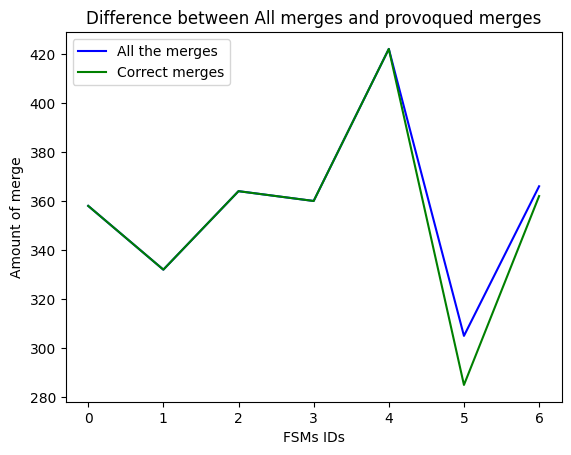

In [2]:
import matplotlib.pyplot as plt

ids = range(7)
acc = []
all_merge = [358, 332, 364, 360, 422, 305, 366]
correct_merge = [358, 332, 364, 360, 422, 285, 362]

plt.plot(ids, all_merge, 'b', label='All the merges')
plt.plot(ids, correct_merge, 'g', label='Correct merges')
plt.title('Difference between All merges and provoqued merges')
plt.xlabel('FSMs IDs')
plt.ylabel('Amount of merge')
plt.legend()
plt.show()